# setting 

## path

In [1]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Credit_Comp/py/models/')
sys.path.append(home_path + '/Desktop/Credit_Comp/py/')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg')

## module

In [2]:
## module
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas_profiling as pdp
from collections import Counter
import scipy
import Base, Classifier # my module
# genetic algorithm
from deap import algorithms, base, creator, tools, gp
import operator, math, time
from tqdm import tqdm
# optuna
from functools import partial
import optuna
# sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.externals.six import StringIO
import sklearn.preprocessing as preproc
# Boosting
from xgboost import XGBClassifier
import lightgbm as lgb
# view
import pydotplus
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/takuto/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/takuto/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [3]:
# moduleの再読み込み(作業中に更新した内容をここで更新できる)
import importlib
importlib.reload(Base)
importlib.reload(Classifier)

# for instance
Process = Base.Process()
Applicate = Base.Applicate()
LightGBM = Classifier.LightGBM()
DecisionTree = Classifier.DecisionTree()

## read data

In [4]:
# base data
train_base, test_base, target = Process.read_data1()

# select features
features_base = test_base.columns.values # 暫定的

27000 observations and 24 features in train set.
3000 observations and 23 features in test set.


# Feature engineering

- 「機械学習のための特徴量エンジニアリング」を参考に

In [99]:
# お試し
# tmp = train_base[['X6','X7','X8','X9','X10','X11']]
# tmp = preproc.PolynomialFeatures(include_bias=False).fit_transform(train_base[['X2','X3','X4']])
# pd.DataFrame(tmp).astype(int)
np.floor_divide(train_base['X5'], 10)

0        2
1        2
2        3
3        5
4        3
5        2
6        2
7        2
8        3
9        3
10       5
11       3
12       2
13       2
14       2
15       4
16       2
17       3
18       2
19       4
20       2
21       2
22       2
23       4
24       2
25       2
26       3
27       3
28       5
29       3
        ..
26970    3
26971    3
26972    3
26973    3
26974    3
26975    3
26976    3
26977    3
26978    4
26979    4
26980    3
26981    3
26982    3
26983    4
26984    4
26985    3
26986    4
26987    3
26988    3
26989    3
26990    3
26991    3
26992    4
26993    3
26994    4
26995    3
26996    4
26997    3
26998    4
26999    4
Name: X5, Length: 27000, dtype: int64

In [108]:
def interaction_features(data,feats):
    # make features name
    feats_ = [feats[i] + '_' +  feats[j] for i in range(len(feats)) for j in range(len(feats)) if i <= j ]
    # execute 
    tmp1 = preproc.PolynomialFeatures(include_bias=False).fit_transform(data[feats])
    tmp2 = pd.DataFrame(tmp1,columns=feats + feats_).astype(int)
    return pd.concat([data,tmp2.drop(feats,axis=1)],axis=1)
def feature_engineering(data):
    ## credit value
    data['log_credit'] = np.log10(data['X1'] + 1) # 対数変換
    tmp1, tmp2 = scipy.stats.boxcox(data['X1']) # Box-Cox変換 (分散安定化)
    data['boxcox_credit'] = tmp1
    data['scaler_credit'] = preproc.StandardScaler().fit_transform(data[['X1']])
    # data['X1'] = np.floor(np.log10(data['X1'] + 1)) # 対数変換 + 離散化 (指数幅の階級割り当て)
    ## user age
    data['bins_ages'] = np.floor_divide(data['X5'], 10) # 離散化 (固定幅)
    ## pay history 
    pay_history = data[['X6','X7','X8','X9','X10','X11']] 
    data['nopay_count'] = (pay_history == -2).sum(axis=1)
    data['pay_count'] = (pay_history == -1).sum(axis=1)
    data['revo_count'] = (pay_history == 0).sum(axis=1)
    data['late_count'] = pay_history.where(pay_history >= 0, 0).sum(axis=1)
    # pay account
    data['log_pay_9'] = np.log10(data['X12'] + 1) # 対数変換
    data['log_pay_8'] = np.log10(data['X13'] + 1) # 対数変換
    data['log_pay_7'] = np.log10(data['X14'] + 1) # 対数変換
    data['log_pay_6'] = np.log10(data['X15'] + 1) # 対数変換
    data['log_pay_5'] = np.log10(data['X16'] + 1) # 対数変換
    data['log_pay_4'] = np.log10(data['X17'] + 1) # 対数変換
    # pre-pay account
    data['log_prepay_9'] = np.log10(data['X18'] + 1) # 対数変換
    data['log_prepay_8'] = np.log10(data['X19'] + 1) # 対数変換
    data['log_prepay_7'] = np.log10(data['X20'] + 1) # 対数変換
    data['log_prepay_6'] = np.log10(data['X21'] + 1) # 対数変換
    data['log_prepay_5'] = np.log10(data['X22'] + 1) # 対数変換
    data['log_prepay_4'] = np.log10(data['X23'] + 1) # 対数変換
    # interaction feature
    data = interaction_features(data.copy(),feats=['X2','X3','X4'])
    # remove column
    rm_column = ['X1','X5','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23'] 
    return data.drop(rm_column,axis=1)

In [109]:
# execute
train = feature_engineering(train_base.copy())
test = feature_engineering(test_base.copy())
features = test.columns.values

/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
/Users/takuto

In [96]:
# check
print(train.head())
print(train_base.head())
print(features)
print(features_base)

   X2  X3  X4  X5  X6  X7  X8  X9  X10  X11  ...    nopay_count  pay_count  \
0   2   2   1  24   2   2  -1  -1   -2   -2  ...              2          2   
1   2   2   2  26  -1   2   0   0    0    2  ...              0          1   
2   2   2   2  34   0   0   0   0    0    0  ...              0          0   
3   1   2   1  57  -1   0  -1   0    0    0  ...              0          2   
4   1   1   2  37   0   0   0   0    0    0  ...              0          0   

   revo_count  late_count  X2_X2  X2_X3  X2_X4  X3_X3  X3_X4  X4_X4  
0           0           4      4      4      2      4      2      1  
1           3           4      4      4      4      4      4      4  
2           6           0      4      4      4      4      4      4  
3           4           0      1      2      1      4      2      1  
4           6           0      1      1      2      1      2      4  

[5 rows x 37 columns]
       X1  X2  X3  X4  X5  X6  X7  X8  X9  X10 ...    X15    X16    X17   X18  \
0   200

# model comparing

- base lightgbm + new lightgbm
- base Decision Tree + new Decision Tree

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.164099	valid_1's binary_error: 0.173481
[200]	training's binary_error: 0.151506	valid_1's binary_error: 0.176444
[300]	training's binary_error: 0.137877	valid_1's binary_error: 0.175704
Early stopping, best iteration is:
[119]	training's binary_error: 0.161086	valid_1's binary_error: 0.172
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.16242	valid_1's binary_error: 0.181481
[200]	training's binary_error: 0.150272	valid_1's binary_error: 0.183704
Early stopping, best iteration is:
[46]	training's binary_error: 0.168938	valid_1's binary_error: 0.178963
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.160593	valid_1's binary_error: 0.183556
[200]	training's binary_error: 0.148494	valid_1's binary_error: 0.186815
Early stopping, best iteration is:
[32]	training's binary_erro

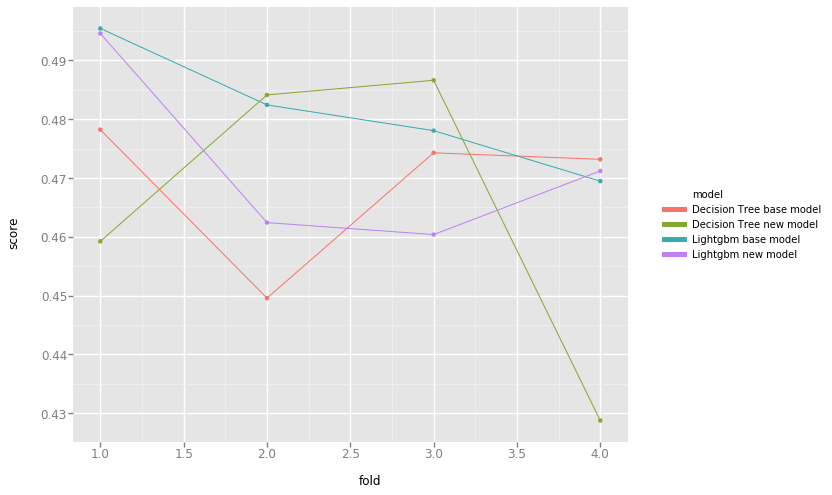

<ggplot: (299895209)>


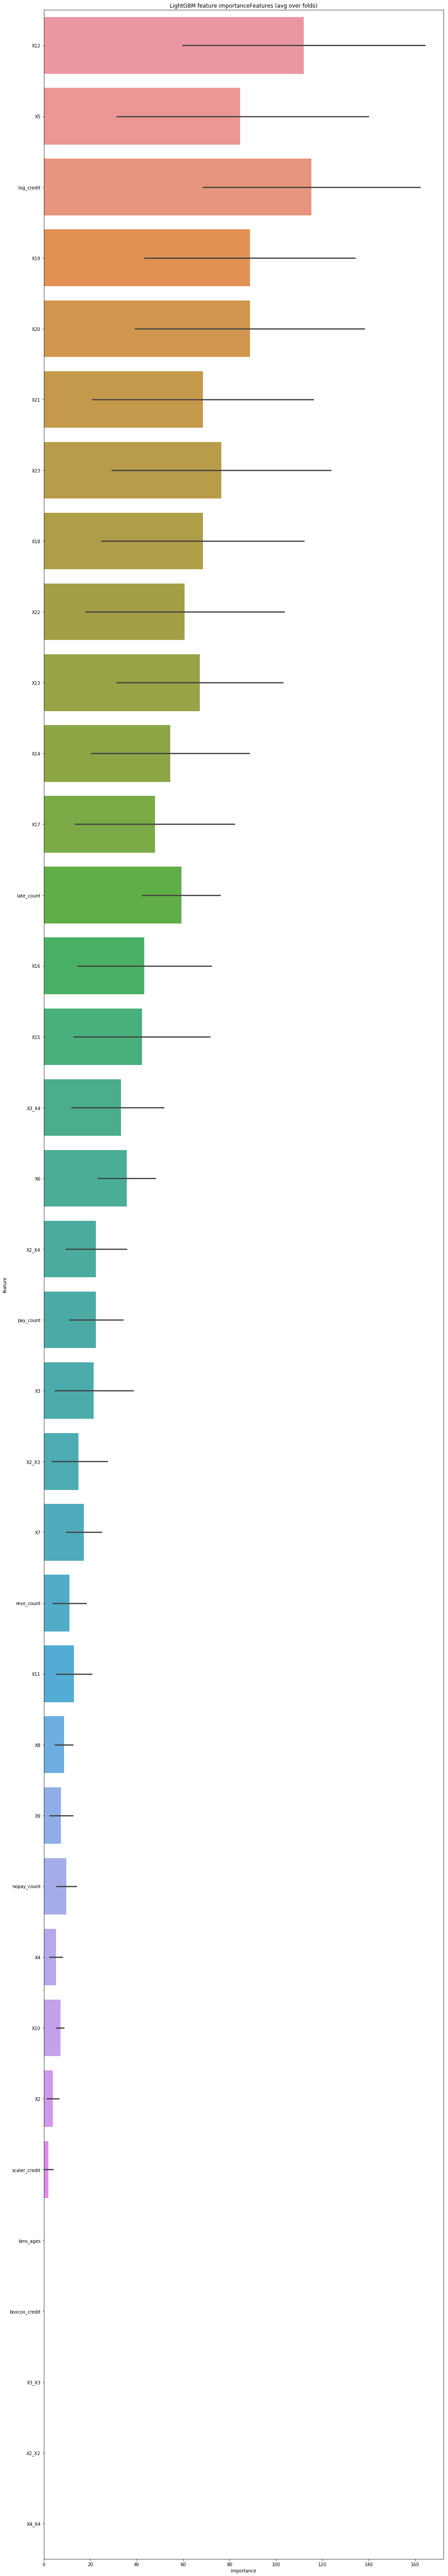

In [97]:
# parameters
tree_param = Process.open_parameter(file_name = 'Tree_classifer_param')
lgb_param = Process.open_parameter(file_name = 'lgb_classifer_param')
# model
lgb_base, importances_base = LightGBM.validation(train_base,features_base,lgb_param,name="Lightgbm base model")
# lgb_new, importances = LightGBM.validation(train_base,features_base,param,name="Lightgbm new model")
lgb_new, importances_new = LightGBM.validation(train,features,lgb_param,name="Lightgbm new model")
tree_base = DecisionTree.validation(train_base,features_base,tree_param, name="Decision Tree base model")
tree_new = DecisionTree.validation(train,features,tree_param, name="Decision Tree new model")

# result
performance = pd.concat([lgb_base,lgb_new,tree_base,tree_new])
g_normal = ggplot(performance,aes(x='fold',y='score',group = 'model',color = 'model')) + geom_point() + geom_line()
print(g_normal)

# feature importance
LightGBM.display_importances(importances_new, title="LightGBM feature importance")

In [72]:
print(lgb_base)
print(lgb_new)

   fold                model     score
0     1  Lightgbm base model  0.495437
1     2  Lightgbm base model  0.482434
2     3  Lightgbm base model  0.478057
3     4  Lightgbm base model  0.469467
   fold               model     score
0     1  Lightgbm new model  0.495437
1     2  Lightgbm new model  0.482434
2     3  Lightgbm new model  0.478057
3     4  Lightgbm new model  0.469467


In [79]:
performance

,fold,model,score
0,1,Lightgbm base model,0.495437
1,2,Lightgbm base model,0.482434
2,3,Lightgbm base model,0.478057
3,4,Lightgbm base model,0.469467
0,1,Lightgbm new model,0.495437
1,2,Lightgbm new model,0.482434
2,3,Lightgbm new model,0.478057
3,4,Lightgbm new model,0.469467
0,1,Decision Tree base model,0.487987
1,2,Decision Tree base model,0.479023


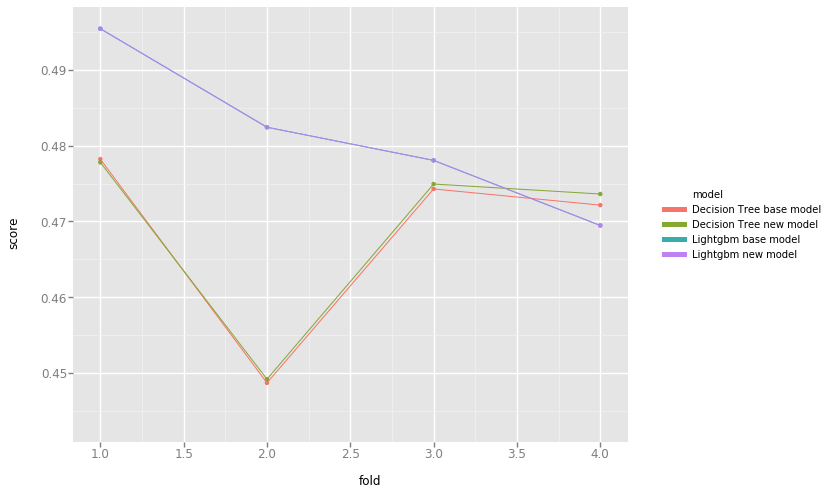

<ggplot: (-9223372036548696071)>


In [23]:
g_normal = ggplot(performance,aes(x='fold',y='score',group = 'model',color = 'model')) + geom_point() + geom_line()
print(g_normal)

In [24]:
features

array(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'Y11', 'Y12', 'Y13', 'Y5'], dtype=object)